Import all modules

In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.metrics import classification_report
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Load Data

In [2]:
IMAGE_SHAPE = (224,224)

In [3]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# load training data
training_data = 'input/train'
training_image_data = image_generator.flow_from_directory(training_data, target_size=IMAGE_SHAPE)

# load validation data
validation_data='input/val'
validation_image_data  = image_generator.flow_from_directory(validation_data,target_size=IMAGE_SHAPE)

Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [4]:
training_image_data[1][1].shape

(32, 5)

Define class names

In [5]:
class_names = sorted(training_image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Anthracnose', 'Black-Mould-Rot', 'Blossom-Blight', 'Healthy',
       'Stem-End-Rot'], dtype='<U15')

Define Pretrained Base

In [6]:
MobileNetV2=tf.keras.applications.mobilenet_v2.MobileNetV2
model_arch=MobileNetV2(weights='imagenet', include_top=False)
model_arch.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

 block_2_add (Add)              (None, None, None,   0           ['block_1_project_BN[0][0]',     
                                24)                               'block_2_project_BN[0][0]']     
                                                                                                  
 block_3_expand (Conv2D)        (None, None, None,   3456        ['block_2_add[0][0]']            
                                144)                                                              
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, None, None,   576        ['block_3_expand[0][0]']         
 ization)                       144)                                                              
                                                                                                  
 block_3_expand_relu (ReLU)     (None, None, None,   0           ['block_3_expand_BN[0][0]']      
          

                                                                                                  
 block_6_expand (Conv2D)        (None, None, None,   6144        ['block_5_add[0][0]']            
                                192)                                                              
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, None, None,   768        ['block_6_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_6_expand_relu (ReLU)     (None, None, None,   0           ['block_6_expand_BN[0][0]']      
                                192)                                                              
                                                                                                  
 block_6_p

                                384)                                                              
                                                                                                  
 block_9_expand_BN (BatchNormal  (None, None, None,   1536       ['block_9_expand[0][0]']         
 ization)                       384)                                                              
                                                                                                  
 block_9_expand_relu (ReLU)     (None, None, None,   0           ['block_9_expand_BN[0][0]']      
                                384)                                                              
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, None, None,   3456       ['block_9_expand_relu[0][0]']    
 nv2D)                          384)                                                              
          

 block_12_expand_relu (ReLU)    (None, None, None,   0           ['block_12_expand_BN[0][0]']     
                                576)                                                              
                                                                                                  
 block_12_depthwise (DepthwiseC  (None, None, None,   5184       ['block_12_expand_relu[0][0]']   
 onv2D)                         576)                                                              
                                                                                                  
 block_12_depthwise_BN (BatchNo  (None, None, None,   2304       ['block_12_depthwise[0][0]']     
 rmalization)                   576)                                                              
                                                                                                  
 block_12_depthwise_relu (ReLU)  (None, None, None,   0          ['block_12_depthwise_BN[0][0]']  
          

                                                                                                  
 block_15_depthwise (DepthwiseC  (None, None, None,   8640       ['block_15_expand_relu[0][0]']   
 onv2D)                         960)                                                              
                                                                                                  
 block_15_depthwise_BN (BatchNo  (None, None, None,   3840       ['block_15_depthwise[0][0]']     
 rmalization)                   960)                                                              
                                                                                                  
 block_15_depthwise_relu (ReLU)  (None, None, None,   0          ['block_15_depthwise_BN[0][0]']  
                                960)                                                              
                                                                                                  
 block_15_

Attach Feature Extractor Head

In [7]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False) 

In [8]:
model = tf.keras.Sequential([feature_extractor])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
for image_batch, label_batch in training_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [10]:
model_mango = tf.keras.Sequential([feature_extractor ])
model_mango.add(tf.keras.layers.Flatten())
model_mango.add(tf.keras.layers.Dropout(0.5))
model_mango.add(tf.keras.layers.Dense(5, activation=tf.keras.activations.softmax))
model_mango.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Compile Model

In [14]:
model_mango.compile(
    optimizer='Adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['acc']
)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Fit Model

In [20]:
history = model_mango.fit(training_image_data,
                          epochs = 25,
                          validation_data=validation_image_data,
                          callbacks=[early_stopping]
                         )

Epoch 1/25
16/16 [==============================] - 13s 840ms/step - loss: 0.3805 - acc: 0.8580 - val_loss: 0.4441 - val_acc: 0.8440
Epoch 2/25
16/16 [==============================] - 12s 775ms/step - loss: 0.3955 - acc: 0.8640 - val_loss: 0.4356 - val_acc: 0.8520
Epoch 3/25
16/16 [==============================] - 12s 772ms/step - loss: 0.3499 - acc: 0.8720 - val_loss: 0.4383 - val_acc: 0.8360
Epoch 4/25
16/16 [==============================] - 14s 922ms/step - loss: 0.3472 - acc: 0.8920 - val_loss: 0.4357 - val_acc: 0.8520
Epoch 5/25
16/16 [==============================] - 18s 1s/step - loss: 0.3360 - acc: 0.8720 - val_loss: 0.4436 - val_acc: 0.8240
Epoch 6/25
16/16 [==============================] - 13s 838ms/step - loss: 0.2987 - acc: 0.9100 - val_loss: 0.4285 - val_acc: 0.8520
Epoch 7/25
16/16 [==============================] - 12s 754ms/step - loss: 0.3200 - acc: 0.8840 - val_loss: 0.4286 - val_acc: 0.8520
Epoch 8/25
16/16 [==============================] - 11s 685ms/step - los

In [21]:
arr = model_mango.predict(image_batch)
predicted_id = np.argmax(arr, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)
true_label_batch = class_names[label_id]

1/1 [==============================] - 0s 474ms/step


Confusion Matrix

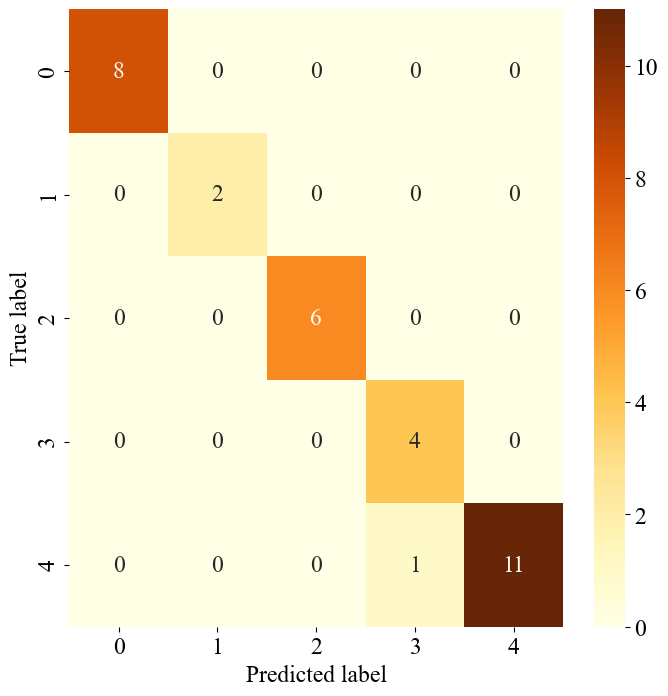

In [22]:
con_mat_df=tf.math.confusion_matrix(labels = label_id , predictions = predicted_id)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 17

figure = plt.figure(figsize=(7, 7))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.YlOrBr)
plt.tight_layout()
plt.ylabel('True label', fontname="Times New Roman")
plt.xlabel('Predicted label', fontname="Times New Roman")
plt.show()

Classification Report

In [23]:
print(classification_report(label_id, predicted_id, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       0.80      1.00      0.89         4
           4       1.00      0.92      0.96        12

    accuracy                           0.97        32
   macro avg       0.96      0.98      0.97        32
weighted avg       0.97      0.97      0.97        32



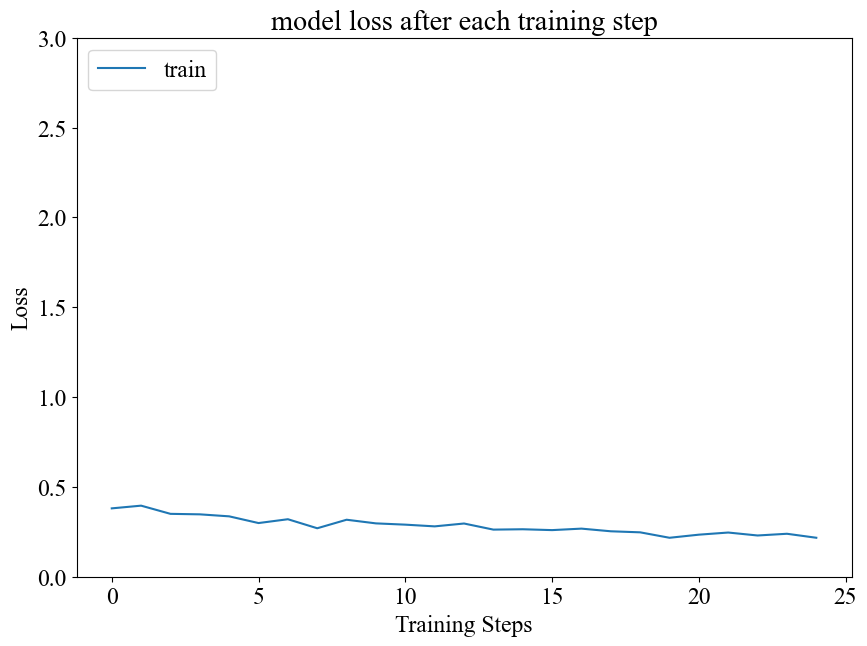

In [24]:
plt.figure(figsize=(10,7))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,3])
plt.plot(history.history['loss'])
plt.title('model loss after each training step')
plt.legend(['train'], loc='upper left')

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


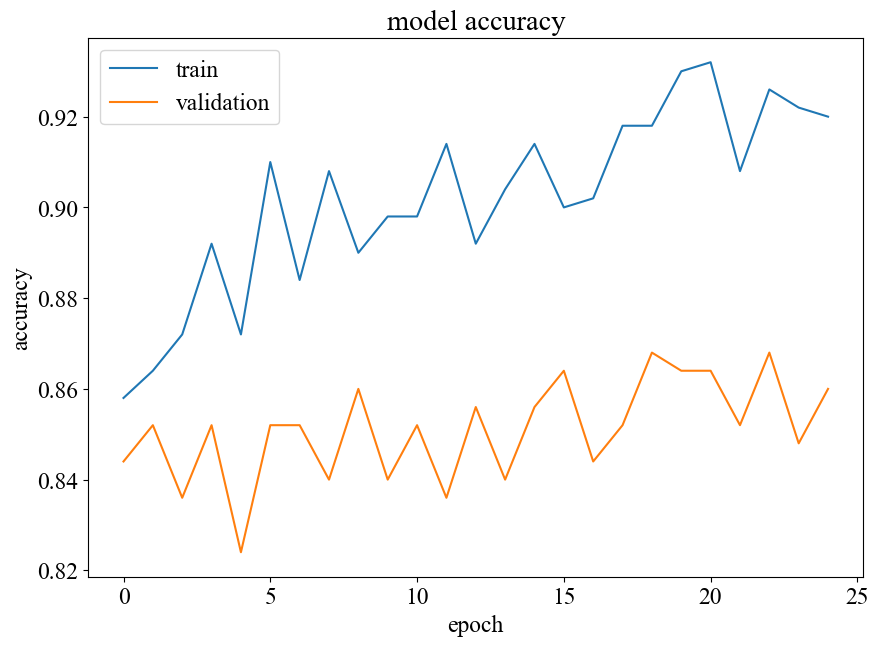

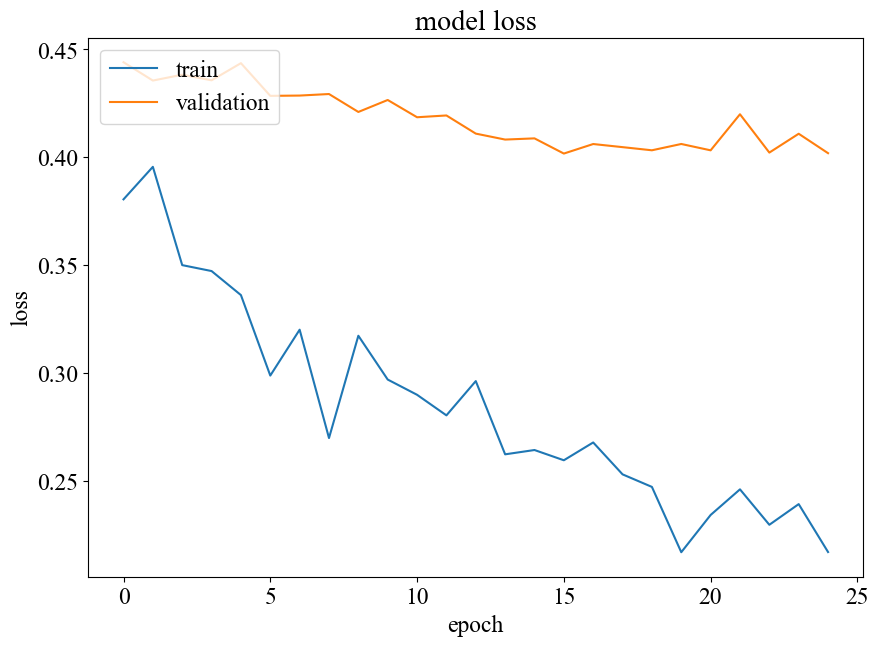

In [25]:
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(10,7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# summarize history for loss
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

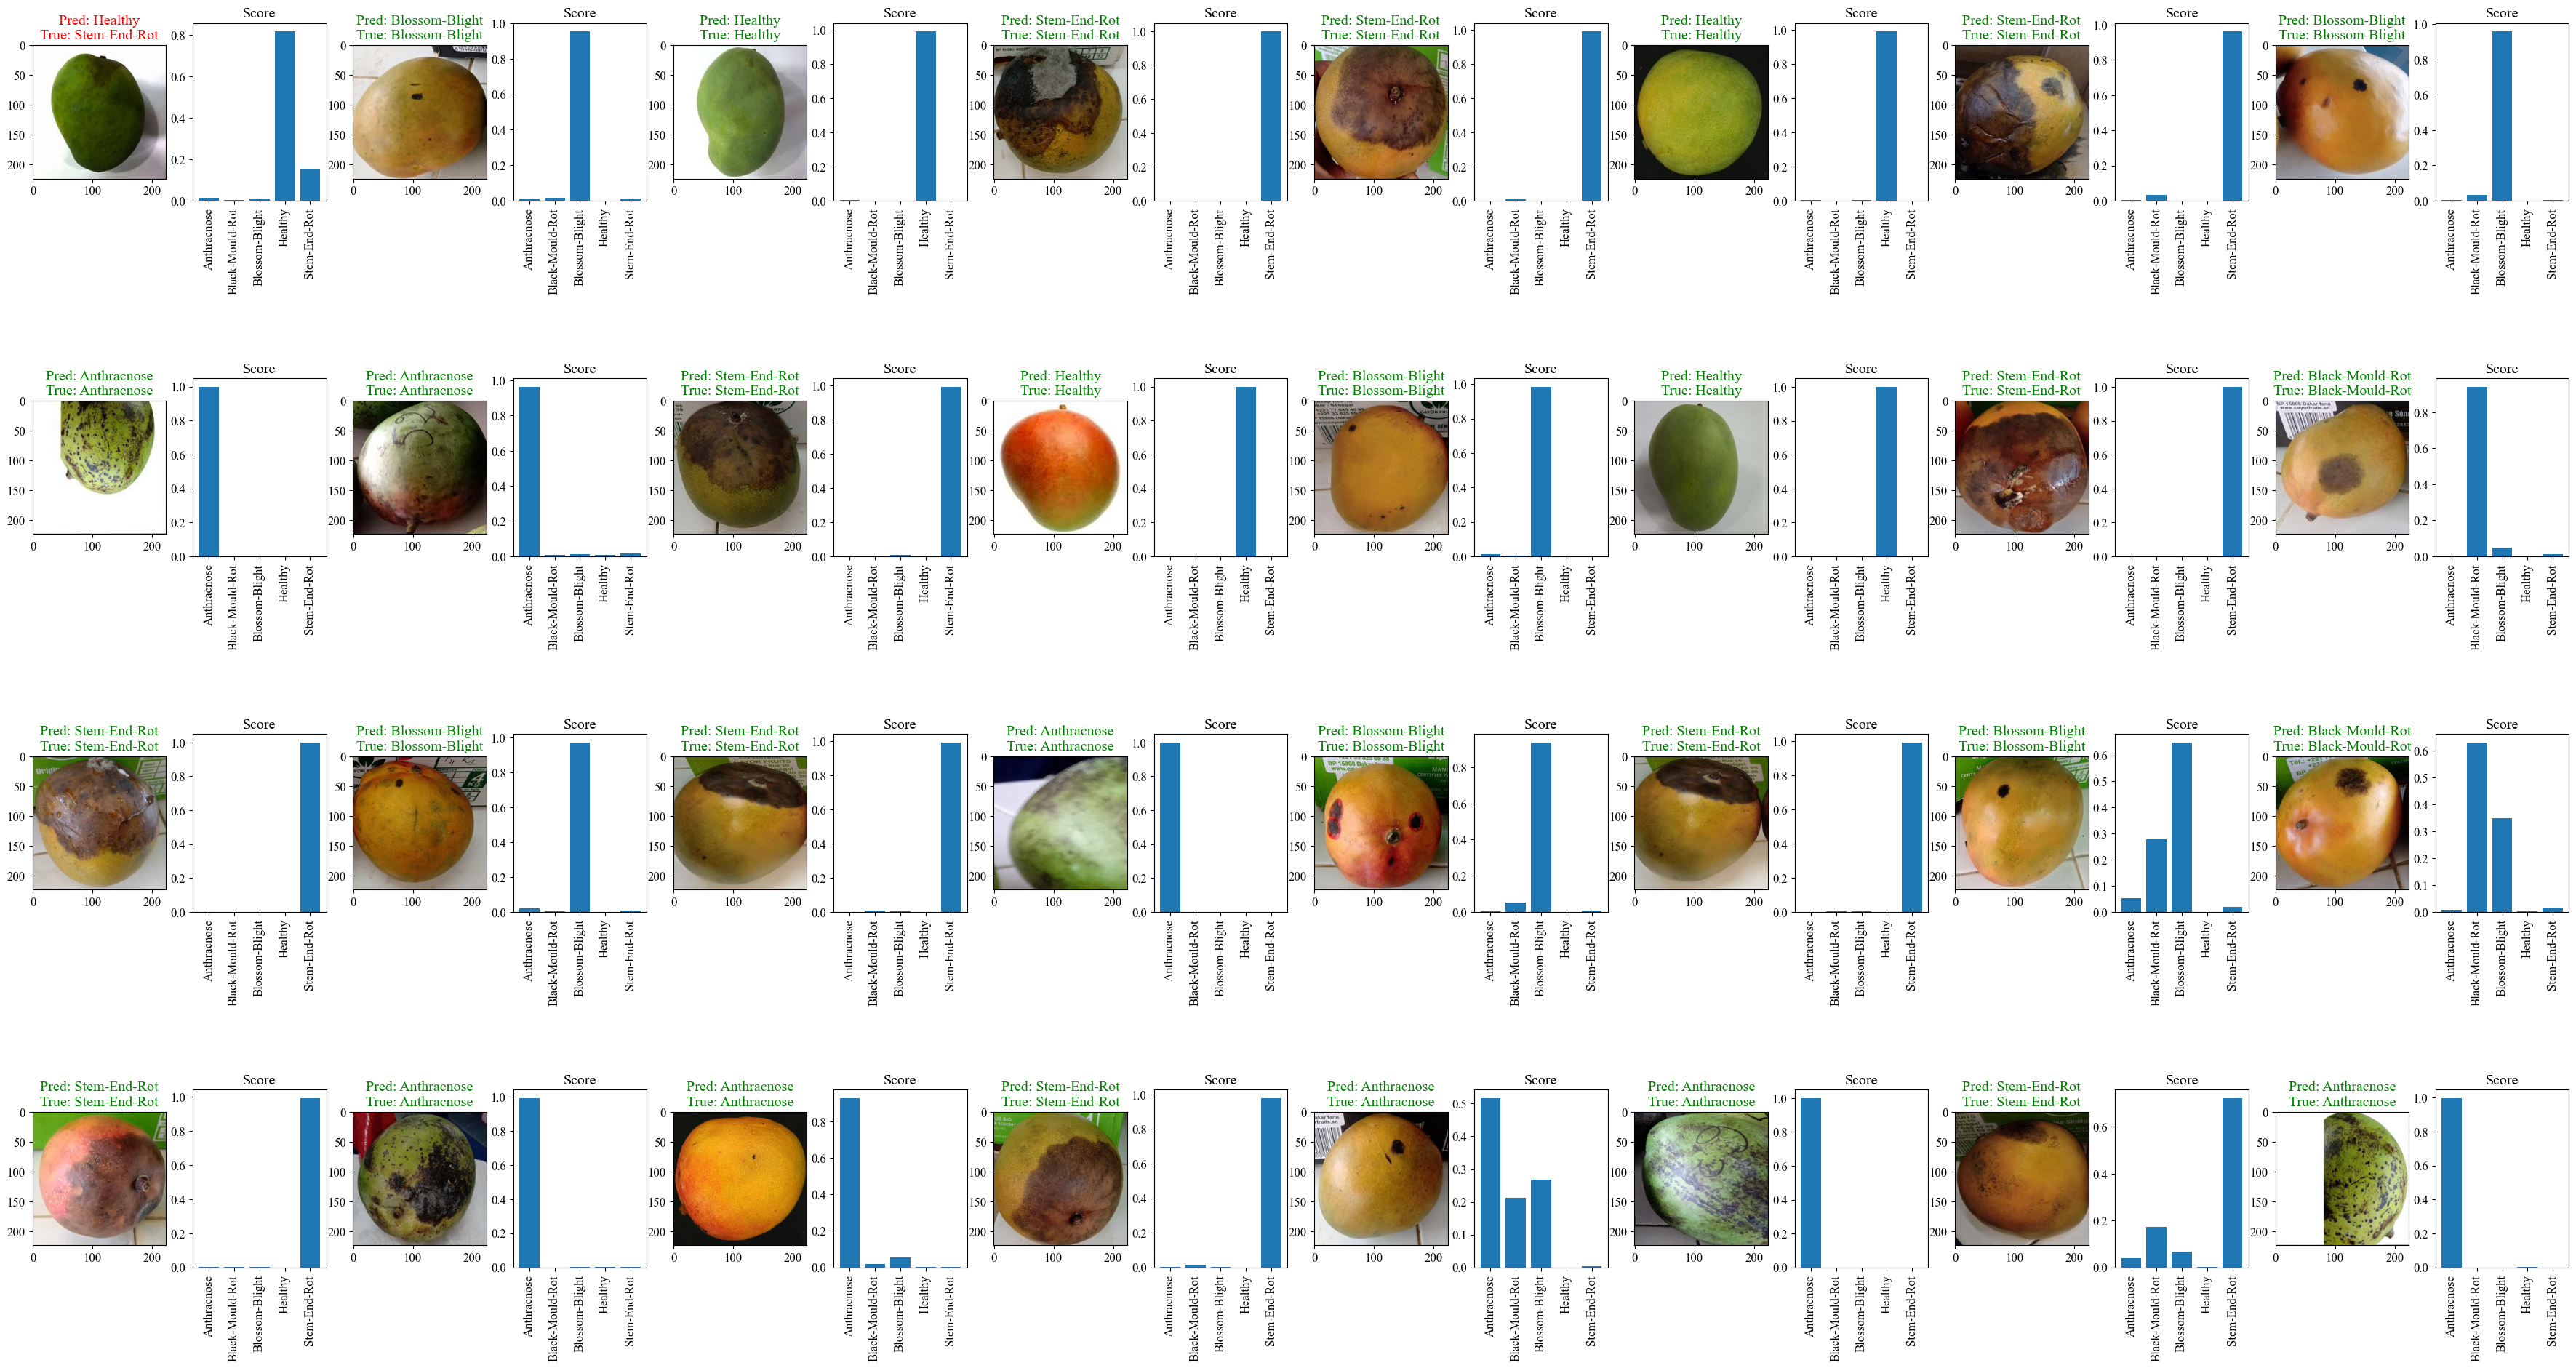

In [26]:
img_counter=0
prob_counter=0

plt.figure(figsize=(45,200))
plt.subplots_adjust(hspace=1)
for n in range(64):
  plt.rcParams['font.size'] = 12
  plt.subplot(32,16,n+1)
  if(n%2==0):
      plt.imshow(image_batch[img_counter])
      color = "green" if predicted_id[img_counter] == label_id[img_counter] else "red"
      plt.title("Pred: "+predicted_label_batch[img_counter].title()+"\nTrue: "+true_label_batch[img_counter], color=color)
      img_counter=img_counter+1

  if(n%2==1):
      plt.title("Score", color="Black")

      data=[arr[prob_counter][0],arr[prob_counter][1],arr[prob_counter][2],
            arr[prob_counter][3], arr[prob_counter][4]
            ]
    
      plt.bar(class_names,data)
      plt.xticks(rotation='vertical')
      
      prob_counter=prob_counter+1 